In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import math
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
from torchvision import models
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
IAM_ROOT = '/home/tobias/datasets/IAM/'

In [4]:
from thesis.data import IAMDataset

ds = IAMDataset(
    IAM_ROOT,
    "word",
    "test",
    return_writer_id=True,
)

ModuleNotFoundError: No module named 'thesis.data'

In [ ]:
ds.data

In [ ]:
def imshow(im):
    plt.imshow(im, cmap='gray')
    plt.axis('off')

## Image statistics per writer

In [8]:
# Collect mean and std per writer
wmeans, wstds = [], []
for wid in ds.data.writer_id.unique():
    wsamples = ds.data[ds.data["writer_id"] == wid]
    means, stds = [], []
    for _, smpl in wsamples.iterrows():
        im = cv.imread(smpl["img_path"], cv.IMREAD_GRAYSCALE)
        mean = im.mean()
        std = im.std()
        means.append(mean)
        stds.append(std)
    wmean = np.mean(mean)
    wstd = np.mean(std)
    wmeans.append(wmean)
    wstds.append(wstd)
    print(wmean, wstd)

227.10289855072463 45.21537811249468
208.1046434859155 71.66373995658334
185.0978494623656 84.22765423131925
213.3156392694064 61.30703220949149
213.2496686986483 67.82050336297718
222.42293906810036 64.26692957688282
211.4450335807706 71.99377330288605
227.5851501619823 55.80076312097776
208.8663450143897 64.36980905273714
197.8726185201595 70.33835523400167
217.37249256166618 65.40189189113451
212.82900432900433 50.68819656786984
220.08856682769726 62.28084800533538
218.63959819032283 59.7648499618842
229.69635627530366 34.578359114540085
233.17101960784314 43.86157869510703
231.29613375130617 41.146879600166464
229.0198949986184 50.98529759947487
213.60693473193473 67.86602339460205
165.2 23.11298336433443
225.98646225569303 49.69462236322574
219.69514695830486 57.9083823710652
218.8009531819456 50.96802671066024
229.93701230492198 44.745898413230805
237.44778809607774 36.92320960178628
197.45384615384614 64.12429175358905
227.36106631249407 44.00370699343077
221.10641627543035 52.5

209.4487058080808 65.30940386961792
234.1407234301971 45.441151714318806
210.84097490347492 63.80984624200204
192.5284210526316 62.820586071359045
214.80718085106383 62.26255700391995
226.7658086594257 47.01934848020273
217.53786535303777 63.091945010152735
221.04279835390946 58.370451032696636
231.49106698379336 43.48703488351699
175.3125 25.765089632097148
126.21428571428571 58.564712158466904
191.2830303030303 71.01582762057656
161.77777777777777 51.22089658443691
207.88363636363636 64.0253721401598
211.7059649122807 62.12842684436061
230.39870500438983 48.7505729291642
220.449608835711 61.51505414332291
225.3441352141314 51.977763510810405
212.24418181818183 63.48543865087659
215.84100358422938 62.95296380663435
198.74510416666666 72.01476936907328
94.83636363636364 69.1670609036526
185.0085691510562 88.92292222120464
218.69237472766883 68.24803800337824
207.4270115689588 72.45541286814
209.2730940934066 71.38857276484704
198.66743261157754 70.06349973132674
201.93718264906425 68.0

177.37195767195766 92.95494247230727
243.36229749631812 27.847804666310154
220.94222222222223 54.78737008643191
174.16399176954732 83.78190664076625
216.17887624466573 52.79800503498319
225.97185787813382 46.47414562071638
223.79101459468964 67.58104776250252
230.57842548076923 47.966983676848784
222.57205333333334 64.1393940958583
221.81076066790354 54.06113887445815
187.784 56.831435057252136
218.20709771511912 60.912769369223206
237.69323442760944 37.78957655866129
226.28678089403655 62.797739477716846
213.01979458450046 60.79274598873149
190.95572167912593 77.07312864815022
227.0634949642625 54.8512405901904
195.7102754237288 78.79237802664439
207.5483189865194 51.266282763946556
233.84214617499288 36.63730292047729
207.36915204678363 60.95276415192758
225.3727408771728 45.10687086386841
149.0 44.542946400907006
188.96317829457365 62.18109804626748
210.72051282051282 63.06386674337297
204.6117886178862 62.654424697695696
221.47014925373134 52.61497577778712
235.02691766361718 32.73

In [19]:
wmeans_all = wmeans[:]
wstds_all = wstds[:]

In [22]:
wmeans = wmeans_all[:50]
wstds = wstds_all[:50]

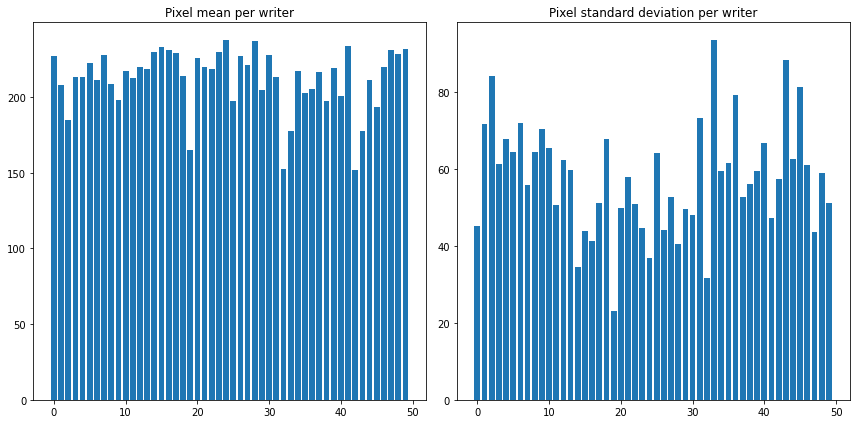

In [27]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Pixel mean per writer")
plt.bar(np.arange(len(wmeans)), wmeans)

plt.subplot(1, 2, 2)
plt.title("Pixel standard deviation per writer")
plt.bar(np.arange(len(wstds)), wstds)

plt.tight_layout()
# plt.savefig("writer_img_statistics.png")

plt.show()

## Batchnorm layer statistics

In [17]:
# Load data
files = [f"../bn_stats/layer_{i}_stats_per_writer.npy" for i in range(20)]

layer_stats = dict()
for i, fname in enumerate(files):
    with open(fname, "rb") as f:
        arr = np.load(f)
        layer_stats[i] = arr

In [30]:
n_writers = len(layer_stats[0])
n_writers

657

In [47]:
# Set hyperparameters
layer_to_plot = 10
num_writers_to_show = 100

In [48]:
# Select a random sample of writers
random.seed(0)
writers_to_plot = random.sample(range(n_writers), num_writers_to_show)

stats = {lid: np.array([layer_stats[lid][wid] for wid in writers_to_plot]) for lid in range(20)}

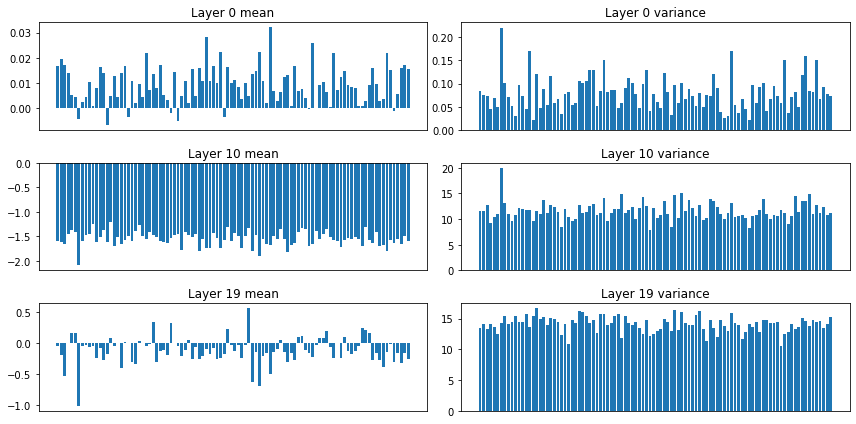

In [55]:
# Plot statistics
def plot_stats(wmeans, wvars, plot_idx):
    plt.subplot(3, 2, plot_idx)
    plt.title(f"Layer {layer} mean")
    plt.xticks([])
    plt.bar(np.arange(len(wmeans)), wmeans)

    plt.subplot(3, 2, plot_idx+1)
    plt.title(f"Layer {layer} variance")
    plt.xticks([])
    plt.bar(np.arange(len(wvars)), wvars)

    
plt.figure(figsize=(12, 6))

layer = 0
wmeans = stats[layer][:, 0]
wvars = stats[layer][:, 1]
plot_stats(wmeans, wvars, 1)

layer = 10
wmeans = stats[layer][:, 0]
wvars = stats[layer][:, 1]
plot_stats(wmeans, wvars, 3)

layer = 19
wmeans = stats[layer][:, 0]
wvars = stats[layer][:, 1]
plot_stats(wmeans, wvars, 5)

plt.tight_layout()
# plt.savefig("bn_statistics.png")

plt.show()

## Old

In [28]:
from htr.data import IAMDataset

iam_mean, iam_std = IAMDataset.MEAN, IAMDataset.STD
# iam_mean, iam_std = 0.8275, 0.2314

In [29]:
from torch.utils.data import DataLoader
from functools import partial

eos_tkn_idx, sos_tkn_idx, pad_tkn_idx = ds.label_enc.transform(
    [ds._eos_token, ds._sos_token, ds._pad_token]
)
collate_fn = partial(
    IAMDataset.collate_fn, pad_val=pad_tkn_idx, eos_tkn_idx=eos_tkn_idx
)
dataloader = DataLoader(
    ds,
    batch_size=16,  # TODO make this higher?
    shuffle=True,
    collate_fn=collate_fn,
)

In [ ]:
bstats = []
for img_batch, _* in dataloader:
    assert img_batch.ndim == 3
    bmean = img_batch.mean()
    bstd = img_batch.std()
    bstats.append((bmean, bstd))
# TODO: continue